<a href="https://colab.research.google.com/github/otman-sarrhini/deep_learning/blob/master/02_pytorch_classification_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# check for gpu
!nvidia-smi

Sun Dec 18 14:39:40 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P0    29W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch

In [3]:
# set device
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
# Make a binary classification dataset with Scikit-Learn's make_moons() function
## Use 1000 samples and set random seed to 42
## Turn data to tensors
## slplit data to train and test with 80% train fraction

from sklearn.datasets import make_moons

NUM_SAMPLES = 1000
RANDOM_SEED = 42

X, y = make_moons(n_samples=NUM_SAMPLES, noise=0.07, random_state=RANDOM_SEED)

print(f"First 10 values of X {X[:10]}")
print(f"Corresponding lables {y[:10]}")

First 10 values of X [[-0.03341062  0.4213911 ]
 [ 0.99882703 -0.4428903 ]
 [ 0.88959204 -0.32784256]
 [ 0.34195829 -0.41768975]
 [-0.83853099  0.53237483]
 [ 0.59906425 -0.28977331]
 [ 0.29009023 -0.2046885 ]
 [-0.03826868  0.45942924]
 [ 1.61377123 -0.2939697 ]
 [ 0.693337    0.82781911]]
Corresponding lables [1 1 1 1 0 1 1 1 1 0]


In [5]:
# turn data into dataframe

import pandas as pd

data_df = pd.DataFrame(
    {"X0": X[:, 0],
     "X1": X[:, 1],
     "y": y}
)

data_df.head()

,X0,X1,y
0,-0.033411,0.421391,1
1,0.998827,-0.442890,1
2,0.889592,-0.327843,1
3,0.341958,-0.417690,1
4,-0.838531,0.532375,0


In [6]:
X.shape, y.shape

((1000, 2), (1000,))

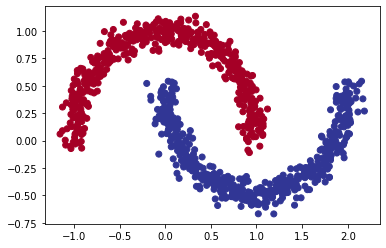

In [7]:
# Visualise data
import matplotlib.pyplot as plt

plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)

In [8]:
# Turn data to tensors and make split

X = torch.from_numpy(X).float()

type(X), X.dtype, X.shape

(torch.Tensor, torch.float32, torch.Size([1000, 2]))

In [9]:
y = torch.from_numpy(y).float()

type(y), y.dtype, y.shape

(torch.Tensor, torch.float32, torch.Size([1000]))

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2,
    random_state=RANDOM_SEED
)

len(X_train), X_train.shape

(800, torch.Size([800, 2]))

In [11]:
import torch.nn as nn

In [12]:
# Model to fit data created

class MoonModelV0(nn.Module):
  def __init__(self, in_features, out_features, hidden_units):
    super().__init__()

    self.model = nn.Sequential(
        nn.Linear(in_features, hidden_units),
        nn.LeakyReLU(negative_slope=0.02),
        nn.Linear(hidden_units, hidden_units),
        nn.LeakyReLU(negative_slope=0.02),
        nn.Linear(hidden_units, out_features)
    )

  def forward(self, x):
    return self.model(x)

    

In [13]:
in_features = X_train.shape[1]
out_features = 1
hidden_units = 10

in_features, out_features, hidden_units

(2, 1, 10)

In [14]:
!pip -q install torchmetrics

In [15]:
from torchmetrics.classification import BinaryAccuracy

In [16]:
accuracy_fn = BinaryAccuracy().to(device)


In [23]:
loss_fn = nn.BCEWithLogitsLoss()

# Setup binary classification compatible loss function and optimizer
torch.cuda.manual_seed(RANDOM_SEED)
model_0 = MoonModelV0(in_features, out_features, hidden_units).to(device)
optimizer = torch.optim.SGD(model_0.parameters(), lr=0.1)

# Create a training and testing loop to train the model
Epochs = 1000

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(Epochs):

  # Put model into train mode
  model_0.train()

  # Make a prediction
  y_logits = model_0(X_train).squeeze() # Squeeze to remove extra 1
  y_preds = torch.round(torch.sigmoid(y_logits))  # turn logits into probabilities
  
  # backpropagation
  loss = loss_fn(y_logits, y_train)
  # loss = loss_fn(y_train, y_logits) # When using line 30 instead of line 29, I get error at line 50

  # Capture accuracy
  acc = accuracy_fn(y_train.int(), y_preds)
  train_accuracies.append(acc.cpu())
  train_losses.append(loss.item())

  # zero grad
  optimizer.zero_grad()
  loss.backward()

  optimizer.step()

  # Evaluate current model on test data
  model_0.eval()
  with torch.inference_mode():
    test_logits = model_0(X_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(y_test, test_logits)

    test_acc = accuracy_fn(y_test.int(), test_preds)

    test_accuracies.append(test_acc.cpu())
    test_losses.append(test_loss.item())

  if epoch % 10 == 0:
    # print current state
    print(f"Epoch: {epoch} | train loss: {loss.item():.4f} | test loss: {test_loss.item():.4f} | train acc: {acc:.3f} | test acc: {test_acc:.3f}")



  



Epoch: 0 | train loss: 0.6936 | test loss: 0.9973 | train acc: 0.582 | test acc: 0.655
Epoch: 10 | train loss: 0.6811 | test loss: 0.9600 | train acc: 0.640 | test acc: 0.665
Epoch: 20 | train loss: 0.6666 | test loss: 0.9334 | train acc: 0.700 | test acc: 0.720
Epoch: 30 | train loss: 0.6452 | test loss: 0.9051 | train acc: 0.832 | test acc: 0.820
Epoch: 40 | train loss: 0.6127 | test loss: 0.8712 | train acc: 0.874 | test acc: 0.850
Epoch: 50 | train loss: 0.5648 | test loss: 0.8215 | train acc: 0.861 | test acc: 0.875
Epoch: 60 | train loss: 0.5043 | test loss: 0.7444 | train acc: 0.856 | test acc: 0.870
Epoch: 70 | train loss: 0.4386 | test loss: 0.6429 | train acc: 0.856 | test acc: 0.850
Epoch: 80 | train loss: 0.3798 | test loss: 0.5266 | train acc: 0.860 | test acc: 0.850
Epoch: 90 | train loss: 0.3359 | test loss: 0.4093 | train acc: 0.864 | test acc: 0.855
Epoch: 100 | train loss: 0.3063 | test loss: 0.3041 | train acc: 0.873 | test acc: 0.855
Epoch: 110 | train loss: 0.2868 

In [20]:
loss

tensor(nan, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [24]:
len(train_losses)

type(train_losses[0]), train_losses[:5]

(float,
 [0.6935648918151855,
  0.6922389268875122,
  0.6909523606300354,
  0.6896969676017761,
  0.6884656548500061])

In [25]:
len(train_accuracies)

type(train_accuracies[0]), train_accuracies[:5]

(torch.Tensor,
 [tensor(0.5825),
  tensor(0.5925),
  tensor(0.5962),
  tensor(0.6025),
  tensor(0.6075)])

In [21]:
import numpy as np

In [26]:
arr_train_losses = np.array(train_losses)
arr_test_losses = np.array(test_losses)
arr_train_accuracies = np.array(train_accuracies)
arr_test_accuracies = np.array(test_accuracies)

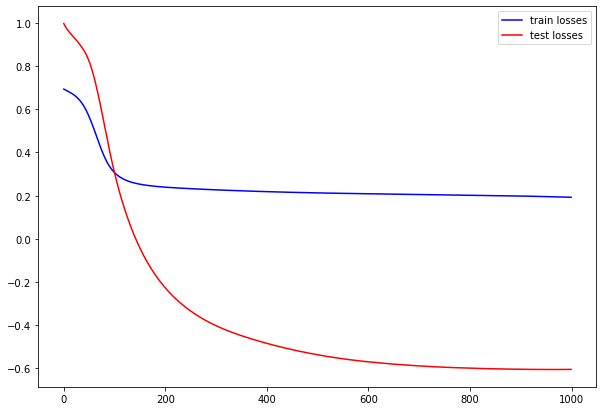

In [27]:
plt.figure(figsize = (10, 7))

plt.plot(range(Epochs), arr_train_losses, c='b', label="train losses")
plt.plot(range(Epochs), arr_test_losses, c='r', label="test losses")
plt.legend()
plt.show()


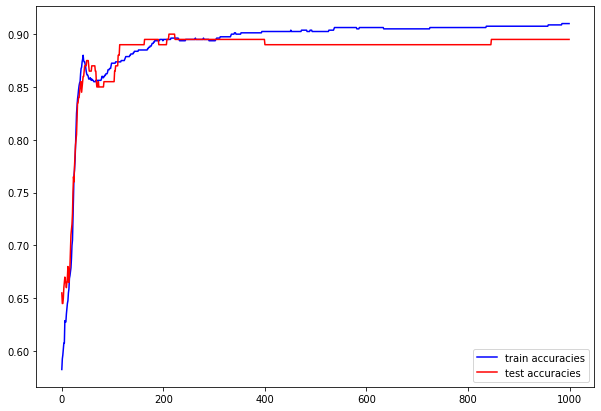

In [28]:
plt.figure(figsize = (10, 7))

plt.plot(range(Epochs), arr_train_accuracies, c='b', label="train accuracies")
plt.plot(range(Epochs), arr_test_accuracies, c='r', label="test accuracies")
plt.legend()
plt.show()